**Simpsons: классификация с дисбалансом классов**
Хорошая модель должна показывать хотя-бы 80% accuracy и учитывать малые классы.

# Обработка датасета



In [ ]:
import zipfile
import pandas as pd
import os
import numpy as np
from tqdm import tqdm  # progress bars

In [ ]:
# (!) загрузить kaggle.json в память колаба !!!
!mkdir -p ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat '/content/kaggle.json': No such file or directory


Буду использовать [Датасет персонажей симпсонов](https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset/data) с Kaggle, тк он содержит выраженный дисбаланс классов.

На лекции уточнила, что можно использовать изображения, не только табличные данные.

In [ ]:
!kaggle datasets download -d alexattia/the-simpsons-characters-dataset

Dataset URL: https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset
License(s): CC-BY-NC-SA-4.0
the-simpsons-characters-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q the-simpsons-characters-dataset.zip -d simpsons_data

replace simpsons_data/annotation.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace simpsons_data/characters_illustration.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
base_path = "simpsons_data"

if not os.path.exists(base_path):
    print(f"Путь {base_path} не существует")
else:
    for root, dirs, files in os.walk(base_path):
        level = root.replace(base_path, "").count(os.sep)
        indent = " " * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = " " * 4 * (level + 1)
        for f in files[:5]:
            print(f"{subindent}{f}")


simpsons_data/
    weights.best.hdf5
    annotation.txt
    number_pic_char.csv
    characters_illustration.png
    simpsons_dataset/
        apu_nahasapeemapetilon/
            pic_0005.jpg
            pic_0447.jpg
            pic_0503.jpg
            pic_0435.jpg
            pic_0162.jpg
        barney_gumble/
            pic_0005.jpg
            pic_0095.jpg
            pic_0029.jpg
            pic_0072.jpg
            pic_0084.jpg
        edna_krabappel/
            pic_0447.jpg
            pic_0435.jpg
            pic_0162.jpg
            pic_0385.jpg
            pic_0425.jpg
        charles_montgomery_burns/
            pic_0870.jpg
            pic_1054.jpg
            pic_0005.jpg
            pic_0447.jpg
            pic_0503.jpg
        krusty_the_clown/
            pic_0870.jpg
            pic_1054.jpg
            pic_0005.jpg
            pic_0447.jpg
            pic_0503.jpg
        carl_carlson/
            pic_0005.jpg
            pic_0095.jpg
            pic_0029.jpg
     

In [ ]:
from collections import Counter
from glob import glob

In [ ]:
# Пути к основным папкам
TRAIN_DIR = "simpsons_data/simpsons_dataset"
TEST_DIR = "simpsons_data/kaggle_simpson_testset/kaggle_simpson_testset"

In [ ]:
# 1. Удалим дубликат вложенной папки, если она есть
dupe_path = os.path.join(TRAIN_DIR, "simpsons_dataset")
if os.path.exists(dupe_path):
    !rm -r "$dupe_path"

In [ ]:
# 2. Соберем train: label берется из имени подпапки
train_data = []
for character in os.listdir(TRAIN_DIR):
    char_dir = os.path.join(TRAIN_DIR, character)
    if os.path.isdir(char_dir):
        for img_path in glob(os.path.join(char_dir, "*.jpg")):
            train_data.append((img_path, character))

In [ ]:
# 3. Соберем test: label берем из имени файла до последнего подчёркивания
# Пример: "bart_simpson_43.jpg" → "bart_simpson"
test_data = []
for img_file in os.listdir(TEST_DIR):
    if img_file.endswith(".jpg"):
        label = "_".join(img_file.split("_")[:-1])
        img_path = os.path.join(TEST_DIR, img_file)
        test_data.append((img_path, label))

In [ ]:
# 4. Объединяем и строим общий датафрейм (потом разделим сами)
all_data = train_data + test_data
df = pd.DataFrame(all_data, columns=["path", "label"])

In [ ]:
print("Размер выборки:", df.shape)
print("Классы:", df["label"].value_counts())
df.head()

Размер выборки: (21923, 2)
Классы: label
homer_simpson               2296
ned_flanders                1503
moe_szyslak                 1502
lisa_simpson                1404
bart_simpson                1392
marge_simpson               1341
krusty_the_clown            1256
principal_skinner           1244
charles_montgomery_burns    1241
milhouse_van_houten         1128
chief_wiggum                1036
abraham_grampa_simpson       961
sideshow_bob                 924
apu_nahasapeemapetilon       673
kent_brockman                548
comic_book_guy               518
edna_krabappel               507
nelson_muntz                 408
lenny_leonard                360
mayor_quimby                 296
waylon_smithers              181
maggie_simpson               128
groundskeeper_willie         121
barney_gumble                106
selma_bouvier                103
carl_carlson                  98
ralph_wiggum                  89
patty_bouvier                 72
martin_prince                 71
pr

,path,label
0,simpsons_data/simpsons_dataset/apu_nahasapeema...,apu_nahasapeemapetilon
1,simpsons_data/simpsons_dataset/apu_nahasapeema...,apu_nahasapeemapetilon
2,simpsons_data/simpsons_dataset/apu_nahasapeema...,apu_nahasapeemapetilon
3,simpsons_data/simpsons_dataset/apu_nahasapeema...,apu_nahasapeemapetilon
4,simpsons_data/simpsons_dataset/apu_nahasapeema...,apu_nahasapeemapetilon


In [ ]:
import matplotlib.pyplot as plt
import random
from PIL import Image

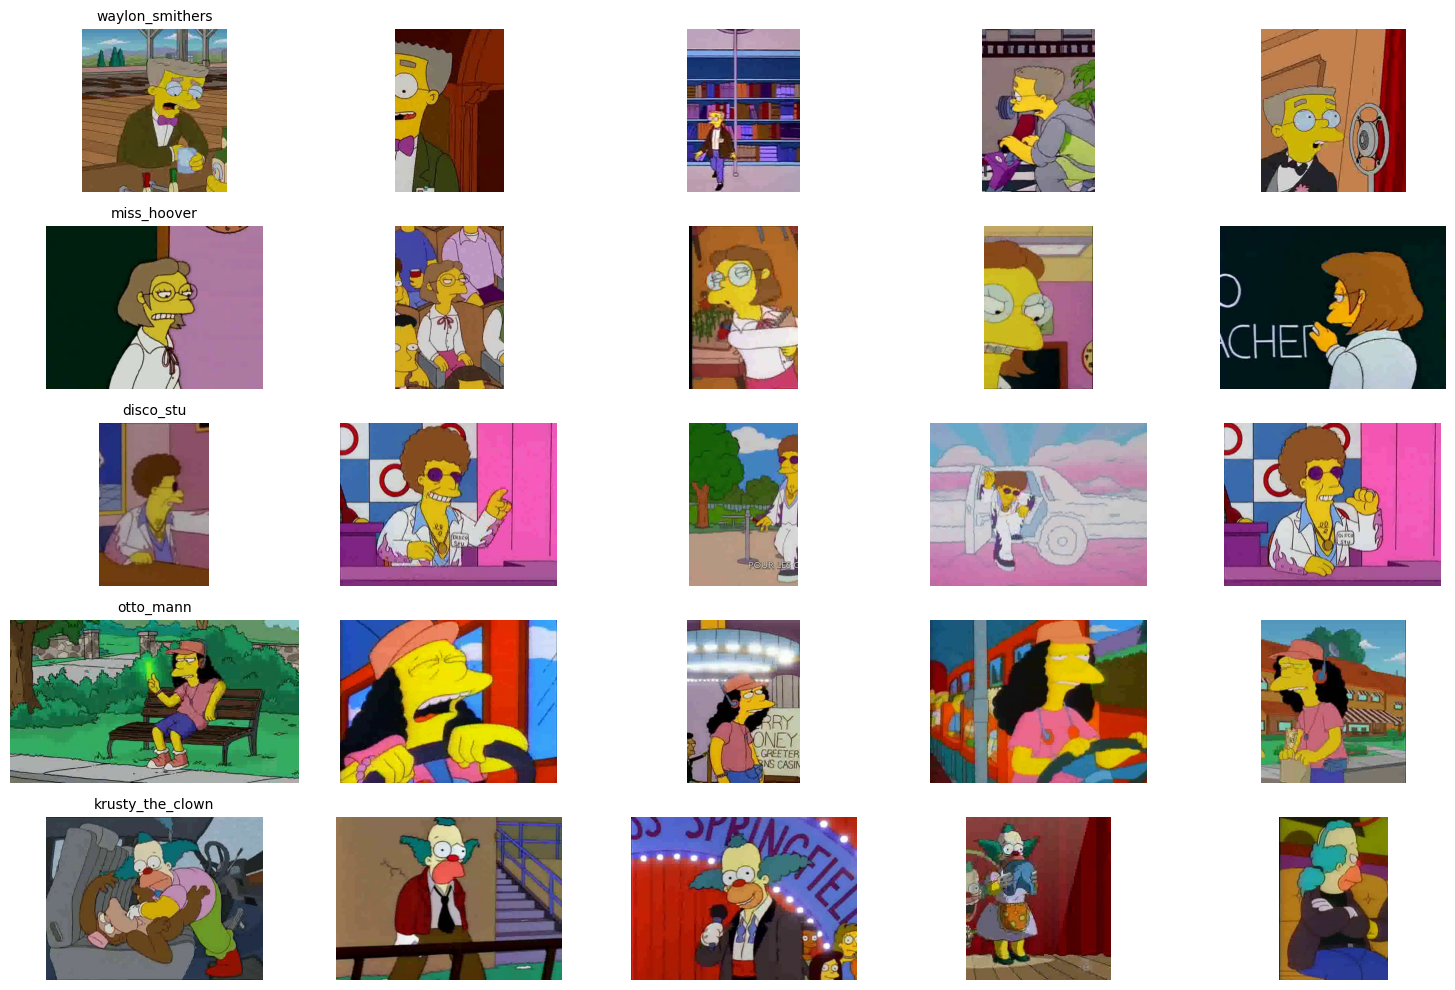

In [ ]:
# 5. Проверка разметки: случайные 5 классов и по 5 изображений на каждый
sampled_labels = random.sample(df["label"].unique().tolist(), 5)

fig, axs = plt.subplots(len(sampled_labels), 5, figsize=(15, 10))
for i, label in enumerate(sampled_labels):
    samples = df[df["label"] == label].sample(5)
    for j, path in enumerate(samples["path"].tolist()):
        img = Image.open(path)
        axs[i, j].imshow(img)
        axs[i, j].axis("off")
        if j == 0:
            axs[i, j].set_title(label, fontsize=10)
plt.tight_layout()
plt.show()

# Данные для модели

In [ ]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [ ]:
# 6. Разделим на train и val
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

In [ ]:
# 7. Создадим словарь классов
target2idx = {label: idx for idx, label in enumerate(sorted(df["label"].unique()))}

In [ ]:
# 8. Трансформации (одинаковый размер файлов, формат для торча из PIL в Tensor)
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
# 9. Кастомный Dataset
# Определяем, как доставать изображения и метки из датафрейма
class SimpsonsDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["path"]).convert("RGB")
        label = target2idx[row["label"]]
        # Ключевой момент: если transform принимает 2 аргумента — передаём label
        if self.transform:
            try:
                image = self.transform(image, label)
            except TypeError:
                image = self.transform(image)
        return image, label

 Кастомный Dataset — это нестандартный класс, который наследуется от torch.utils.data.Dataset и переопределяет два метода:

__len__() — чтобы PyTorch знал, сколько у нас объектов,

__getitem__() — чтобы PyTorch умел доставать изображение и метку по индексу.

В отличие от встроенных датасетов (torchvision.datasets.CIFAR10, MNIST, и т.п.), кастомный позволяет загружать данные из своей структуры: например, из датафрейма, папок, CSV-файла или с разметкой по-своему.

В нашем случае — у нас данные в датафрейме df, поэтому важно было объяснить, что откуда брать.

In [ ]:
# 10. DataLoader — созадем поток батчей данных, готовых к обучению модели
train_dataset = SimpsonsDataset(train_df, transform=data_transforms)
val_dataset = SimpsonsDataset(val_df, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
# Проверим изображения после трансформаций
images, labels = next(iter(train_loader))

print("Форма батча:", images.shape)

Форма батча: torch.Size([64, 3, 64, 64])


# Обслуживающие фи-и

In [ ]:
# Настройка нотификаций

import requests
from IPython.display import Audio, display

#TELEGRAM_TOKEN = '' from env!
CHAT_ID = '36895840'

def notify_bot(message="✅ Задача завершена!"):
    """Уведомление в Telegram и звуковой сигнал в браузере"""
    try:
        # Отправляем сообщение в Telegram
        telegram_url = f"https://api.telegram.org/bot{TELEGRAM_TOKEN}/sendMessage"
        payload = {"chat_id": CHAT_ID, "text": message}
        response = requests.post(telegram_url, data=payload)
        if response.status_code != 200:
            print("⚠️ Ошибка отправки в Telegram:", response.text)
    except Exception as e:
        print("⚠️ Ошибка Telegram:", e)

# notify_bot("✅ Ячейка отработала")

In [ ]:
# Статус бары
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

def plot_metrics(history):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].plot(history['train_loss'], label='Train Loss')
    ax[0].plot(history['val_loss'], label='Val Loss')
    ax[0].set_title('Loss Curves')
    ax[0].legend()

    ax[1].plot(history['train_acc'], label='Train Accuracy')
    ax[1].plot(history['val_acc'], label='Val Accuracy')
    ax[1].set_title('Accuracy Curves')
    plt.show()

def plot_class_metrics(report):
    metrics = ['precision', 'recall', 'f1-score']
    classes = list(report.keys())[:-3]  # Исключаем макро/взвешенные

    fig, ax = plt.subplots(3, 1, figsize=(12, 15))
    for i, metric in enumerate(metrics):
        values = [report[cls][metric] for cls in classes]
        ax[i].bar(classes, values)
        ax[i].set_title(f'{metric.capitalize()} by Class')
        ax[i].tick_params(axis='x', rotation=90)
    plt.tight_layout()
    plt.show()

In [ ]:
# Сохранение результатов на диск
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: 

In [ ]:
import os

folder_path = '/content/drive/MyDrive/Neuro_LLM/Simpsons'

#проверяем подключение
file_list = os.listdir(folder_path)
for filename in file_list:
    print(filename)

In [ ]:
# путь для сохранения весов

main_model_path = "/content/drive/MyDrive/Neuro_LLM/Simpsons/main_model_weights2.pth"
rare_model_path = "/content/drive/MyDrive/Neuro_LLM/Simpsons/rare_model_weights2.pth"

# Архитектура модели

**Стратегия обучения:**

✅ 1. Базовая модель (main_model). Обучается на всех классах.
Использует CrossEntropyLoss с весами по классам (с учётом support).

✅ 2. Список редких классов
Выделяются классы с support <= N (например, 20). Эти классы запоминаются как rare_classes.

✅ 3. Отдельная модель для редких (rare_model)
Обучается только на train_df, содержащем редкие классы.

Использует аугментацию и другие loss-функции (например, FocalLoss).

✅ 4. Класс CombinedModel
Оборачивает main_model и rare_model.

Внутри forward():
* Делает предсказание main_model,
* Если оно попадает в rare_classes, передаёт вход rare_model для уточнения,
* Возвращает единый logits.

✅ 5. Делаем больше эпох

✅ 6. ResNet = 34

✅ 7. Оптимизация обучения - ранняя остановка по F1-score

In [ ]:
# 11. Классификация на предобученно ResNet
# CNN для задач классификации изображений от Microsoft
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch import nn
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from glob import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter

In [ ]:
class Config:
    # Архитектура моделей
    base_model: str = 'resnet34'
    pretrained: bool = True
    num_classes: int = len(target2idx)
    class_weights: torch.Tensor

    # Параметры DataLoader
    main_batch_size: int = 64
    rare_batch_size: int = 32
    val_batch_size: int = 64
    num_workers: int = 0

    # Гиперпараметры обучения
    main_epochs: int = 3      # Для основной модели
    rare_epochs: int = 20     # Для редкой модели
    lr: float = 1e-3
    early_stop_patience: int = 3

    # Пути сохранения
    main_model_path = "/content/drive/MyDrive/Neuro_LLM/Simpsons/main_model_weights2.pth"
    rare_model_path = "/content/drive/MyDrive/Neuro_LLM/Simpsons/rare_model_weights2.pth"
    #plots_dir: str = '/content/plots/'

In [ ]:
def train_model(
    model,
    train_loader,
    val_loader,
    epochs,
    model_path,
    criterion=None,
    optimizer=None,
    early_stop_patience=3,
    target_metric='f1'
):
    optimizer = optimizer or torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = criterion or nn.CrossEntropyLoss()
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': []}
    best_metric = 0
    early_stop_counter = 0

    try:
        for epoch in range(epochs):
            model.train()
            epoch_loss = 0
            correct = 0
            total = 0

            pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                pbar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'acc': f"{correct/total:.4f}"
                })

            # Валидация
            val_loss, val_acc, val_f1 = validate(model, val_loader, criterion)
            history['train_loss'].append(epoch_loss/len(train_loader))
            history['val_loss'].append(val_loss)
            history['train_acc'].append(correct/total)
            history['val_acc'].append(val_acc)
            history['val_f1'].append(val_f1)

            current_metric = val_f1 if target_metric == 'f1' else val_acc
            if current_metric > best_metric:
                best_metric = current_metric
                torch.save(model.state_dict(), model_path)
                early_stop_counter = 0
            else:
                early_stop_counter += 1
                if early_stop_counter >= early_stop_patience:
                    print(f"Ранняя остановка на эпохе {epoch+1}")
                    break

        # Финальная оценка и визуализация
        model.load_state_dict(torch.load(model_path))
        final_report = validate_full(model, val_loader)
        plot_metrics(history)
        plot_class_metrics(final_report)
        notify_bot("✅ Обучение завершено успешно!")
        return model, history

    except Exception as e:
        notify_bot(f"❌ Ошибка во время обучения: {str(e)}")
        raise


Оптимизатор — это алгоритм, который используется для минимизации функции потерь (сила отличий предсказаний от факта).

**Преимущества Adam:**

* Эффективность: Adam обычно сходится быстрее, чем другие оптимизаторы, такие как SGD (Stochastic Gradient Descent).
* Адаптивность: Adam автоматически настраивает скорость обучения для каждого параметра, что позволяет ему эффективно работать с различными типами данных и архитектурами моделей.
* Масштабируемость: Adam хорошо работает с большими наборами данных и сложными моделями.

**CrossEntropyLoss в pyTorch**

Объединяет в себе две операции:

* Softmax — преобразование выходных значений модели (logits) в вероятности, чтобы выбрать наиболее вероятный класс.
* Categorical cross-entropy— вычисление функции потерь на основе вероятностей (закодированных) и истинных меток.


In [ ]:
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = correct / total
    val_f1 = f1_score(all_labels, all_preds, average='macro')

    return val_loss, val_acc, val_f1, all_labels, all_preds


In [ ]:
def validate_full(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return generate_report(all_labels, all_preds)

# 6. Запуск обучения
try:
    trained_model, training_history = train_model(main_model, train_loader_main, val_loader)
except Exception as e:
    print(f"Ошибка во время обучения: {str(e)}")

Ошибка во время обучения: train_model() missing 2 required positional arguments: 'epochs' and 'model_path'


# Аугментация и веса

In [ ]:
# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #активация движков из colab pro
#model = model.to(device)
print(f"Используется устройство: {device}")

Используется устройство: cuda


In [ ]:
image_paths = glob("/content/simpsons_data/simpsons_dataset/**/*.jpg", recursive=True)
data = [(p, os.path.basename(os.path.dirname(p))) for p in image_paths]
#df = pd.DataFrame(data, columns=["path", "label"])

labels = sorted(df["label"].unique())
target2idx = {label: idx for idx, label in enumerate(labels)}
idx2target = {idx: label for label, idx in target2idx.items()}
num_classes = len(labels)

df["target"] = df["label"].map(target2idx)
train_df, val_df = train_test_split(df, stratify=df["label"], test_size=0.2, random_state=42)
# перезапустить класс SimpsonsDataset(Dataset)

In [ ]:
# 1. Базовые трансформации (без аугментации)
base_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [ ]:
# Аугментация для редких классов
rare_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0), ratio=(0.95, 1.05)),
    transforms.RandomAffine(10, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.07, contrast=0.07, saturation=0.07, hue=0.01),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [ ]:
from torch.utils.data import WeightedRandomSampler

# Считаем веса для оверсемплинга
rare_counts = rare_df['label'].value_counts()
rare_weights = 1. / rare_counts[rare_df['label']].values
sampler_rare = WeightedRandomSampler(weights=rare_weights, num_samples=len(rare_weights), replacement=True)

In [ ]:
num_classes = len(target2idx)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #активация движков из colab pro
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# model.fc = nn.Linear(model.fc.in_features, num_classes)
# меняем последний слой предобученной нейронки кастомным под нашу задачу

In [ ]:
# 3. Подсчёт весов по классам для базовой модели
counts = Counter(train_df["label"])
total = sum(counts.values())
class_weights = [total / counts[idx2target[i]] for i in range(num_classes)]
weights_tensor = torch.tensor(class_weights).float().to(device)

In [ ]:
from torch.utils.data import WeightedRandomSampler
import pandas as pd
import numpy as np

class WeightedSampler(WeightedRandomSampler):
    def __init__(self, dataframe, target_column='target', beta=0.999):
        """
        dataframe: pd.DataFrame с метками классов
        target_column: название столбца с метками
        beta: параметр балансировки (0.999 для сильного учёта дисбаланса)
        """
        # Вычисляем веса для каждого класса
        class_counts = dataframe[target_column].value_counts().sort_index()
        weights = 1.0 / (class_counts ** beta)

        # Сопоставляем веса каждому образцу
        sample_weights = dataframe[target_column].map(weights).values
        super().__init__(
            weights=torch.DoubleTensor(sample_weights),
            num_samples=len(dataframe),
            replacement=True
        )

# Разделение выборок на основную и редкую

In [ ]:
# 4. Выделение редких классов
# Основано на предыдущих classification_report
rare_labels = [cls for cls, count in counts.items() if count <= 100]
rare_df = train_df[train_df["label"].isin(rare_labels)].reset_index(drop=True)
common_df = train_df[~train_df["label"].isin(rare_labels)].reset_index(drop=True)

In [ ]:
# Таблица редких классов
rare_counts = pd.DataFrame.from_dict(counts, orient='index', columns=['count'])
rare_counts = rare_counts.loc[rare_labels].sort_values(by="count")
print("Редкие классы (support <= 100):")
print(rare_counts)

Редкие классы (support <= 100):
                      count
lionel_hutz               2
troy_mcclure              6
disco_stu                 6
miss_hoover              14
gil                      22
fat_tony                 22
otto_mann                26
sideshow_mel             32
agnes_skinner            34
rainier_wolfcastle       36
cletus_spuckler          38
snake_jailbird           44
professor_john_frink     52
martin_prince            57
patty_bouvier            58
ralph_wiggum             71
carl_carlson             78
selma_bouvier            82
barney_gumble            85
groundskeeper_willie     97


In [ ]:
from sklearn.model_selection import train_test_split

def stratified_split(df, test_size=0.2, random_state=42):
    # Удаляем классы, которые встречаются только 1 раз (иначе stratify не сработает)
    label_counts = df['label'].value_counts()
    valid_labels = label_counts[label_counts > 1].index
    df = df[df['label'].isin(valid_labels)].reset_index(drop=True)

    train_df, val_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df["label"],
        random_state=random_state
    )
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True)


In [ ]:
train_df, val_df = stratified_split(df)

# Визуализация

In [ ]:
def plot_metrics(history):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].plot(history['train_loss'], label='Train Loss')
    ax[0].plot(history['val_loss'], label='Val Loss')
    ax[0].set_title('Loss Curves')
    ax[0].legend()

    ax[1].plot(history['train_acc'], label='Train Accuracy')
    ax[1].plot(history['val_acc'], label='Val Accuracy')
    ax[1].set_title('Accuracy Curves')

    #plt.savefig(f"{cfg.plots_dir}training_metrics.png")
    plt.show()

In [ ]:
def plot_class_metrics(report):
    metrics = ['precision', 'recall', 'f1-score']
    classes = list(report.keys())[:-3]

    fig, ax = plt.subplots(3, 1, figsize=(15, 15))
    for i, metric in enumerate(metrics):
        values = [report[cls][metric] for cls in classes]
        ax[i].bar(classes, values)
        ax[i].set_title(f'{metric.capitalize()} by Class')
        ax[i].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    #plt.savefig(f"{cfg.plots_dir}class_metrics.png")
    plt.show()

In [ ]:
def generate_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=[idx2target[i] for i in range(cfg.num_classes)], output_dict=True)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[idx2target[i] for i in range(cfg.num_classes)],
                yticklabels=[idx2target[i] for i in range(cfg.num_classes)])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    #plt.savefig(f"{cfg.plots_dir}confusion_matrix.png")
    plt.show()

    return report

# Обучение

## Настройки

In [ ]:
cfg = Config()
cfg.class_weights = weights_tensor

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
# 5. Датасеты
# (!) перезапустить класс SimpsonsDataset
train_dataset_main = SimpsonsDataset(common_df, transform=base_transforms)

#train_dataset_rare = SimpsonsDataset(rare_df, transform=rare_transforms_augmented)
train_dataset_rare = SimpsonsDataset(rare_df, transform=rare_transforms)
val_dataset = SimpsonsDataset(val_df, transform=base_transforms)

In [ ]:
val_df_rare = val_df[val_df['label'].isin(rare_labels)].reset_index(drop=True)
val_dataset_rare = SimpsonsDataset(val_df_rare, transform=base_transforms)  # или rare_transforms, если хочешь аугментацию на val
val_loader_rare = DataLoader(val_dataset_rare, batch_size=64, shuffle=False, num_workers=2)

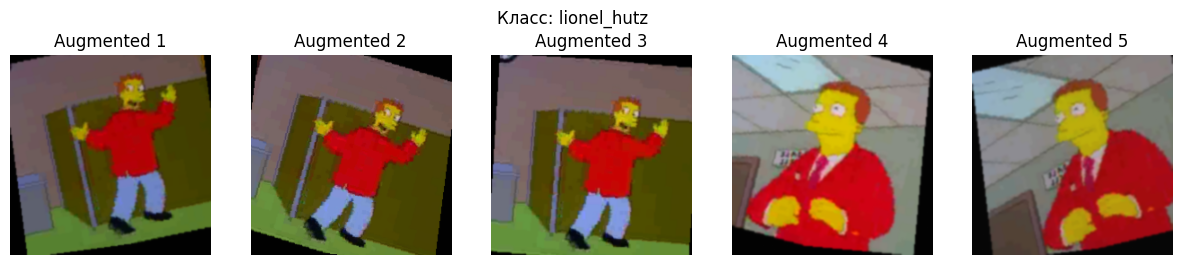

In [ ]:
# проверка аугментации редких класов
import random
import matplotlib.pyplot as plt
import torch

def show_augmented_examples(dataset, label, n=5):
    idxs = [i for i, row in dataset.df.iterrows() if row['label'] == label]
    if not idxs:
        print(f"Нет изображений для класса '{label}' в этом датасете!")
        return
    plt.figure(figsize=(15, 3))
    for i in range(n):
        img_path = dataset.df.iloc[random.choice(idxs)]['path']
        img = Image.open(img_path).convert("RGB")
        aug_img = dataset.transform(img)
        # Если тензор на GPU — переносим на CPU
        if isinstance(aug_img, torch.Tensor):
            aug_img = aug_img.cpu()
        img_np = aug_img.permute(1, 2, 0).numpy()
        # Обратная нормализация
        img_np = img_np * 0.5 + 0.5
        img_np = img_np.clip(0, 1)
        plt.subplot(1, n, i+1)
        plt.imshow(img_np)
        plt.axis("off")
        plt.title(f"Augmented {i+1}")
    plt.suptitle(f"Класс: {label}")
    plt.show()

# Пример вызова:
show_augmented_examples(train_dataset_rare, label="lionel_hutz", n=5) #troy_mcclure

In [ ]:
# Лоадеры (разбивает датасет на батчи)
cfg = Config()

train_loader_main = DataLoader(
    train_dataset_main,
    batch_size=cfg.main_batch_size,  # Например 64
    shuffle=True,
    num_workers=cfg.num_workers,
    pin_memory=True  # Ускоряет передачу данных на GPU
)

In [ ]:
rare_counts = rare_df['label'].value_counts()
rare_weights = 1. / rare_counts[rare_df['label']].values
sampler_rare = WeightedRandomSampler(weights=rare_weights, num_samples=len(rare_weights), replacement=True)

train_loader_rare = DataLoader(
    train_dataset_rare,
    batch_size=32,
    sampler=sampler_rare,
    num_workers=2,
    pin_memory=True
)

In [ ]:
val_loader = DataLoader(
    val_dataset,
    batch_size=cfg.val_batch_size,  # 128 для ускорения
    shuffle=False
)

## Основная модель

In [ ]:
# 2. Инициализация основной модели
main_model = models.__dict__[cfg.base_model](pretrained=cfg.pretrained)
main_model.fc = nn.Linear(main_model.fc.in_features, cfg.num_classes)
main_model = main_model.to(device)

criterion_main = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer_main = torch.optim.Adam(main_model.parameters(), lr=1e-3)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from sklearn.metrics import f1_score

main_model.train()
num_epochs = 3  # или другое нужное тебе число эпох

for epoch in range(num_epochs):
    running_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    pbar = tqdm(train_loader_main, desc=f"[Main model] Эпоха {epoch + 1}/{num_epochs}")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer_main.zero_grad()
        outputs = main_model(images)
        loss = criterion_main(outputs, labels)
        loss.backward()
        optimizer_main.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        # Для F1
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{correct/total:.3f}"
        })
    # F1-score по эпохе
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"Эпоха {epoch+1}: loss={running_loss/len(train_loader_main):.4f}, acc={correct/total:.4f}, f1={epoch_f1:.4f}")

torch.save(main_model.state_dict(), main_model_path)
notify_bot("✅ Ячейка отработала")

[Main model] Эпоха 1/3:   0%|          | 0/261 [00:00<?, ?it/s]

Эпоха 1: loss=0.1569, acc=0.9503, f1=0.9348


[Main model] Эпоха 2/3:   0%|          | 0/261 [00:00<?, ?it/s]

Эпоха 2: loss=0.0956, acc=0.9682, f1=0.9646


[Main model] Эпоха 3/3:   0%|          | 0/261 [00:00<?, ?it/s]

Эпоха 3: loss=0.0690, acc=0.9772, f1=0.9714


## Редкам модел

In [ ]:
# 7. Обучение модели для редких классов
rare_model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
rare_model.fc = nn.Linear(rare_model.fc.in_features, num_classes)
rare_model = rare_model.to(device)

In [ ]:
# Используем FocalLoss для редких классов (опционально)
# Лучше подходит при дисбалансе и делает акцент на сложные для классификации примеры
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        logpt = nn.functional.log_softmax(inputs, dim=1)
        pt = torch.exp(logpt)
        logpt = logpt.gather(1, targets.view(-1, 1))
        pt = pt.gather(1, targets.view(-1, 1))
        loss = -self.alpha * (1 - pt) ** self.gamma * logpt
        return loss.mean() if self.reduction == 'mean' else loss.sum()

In [ ]:
#criterion_rare = FocalLoss()
criterion_rare = nn.CrossEntropyLoss()
optimizer_rare = torch.optim.Adam(rare_model.parameters(), lr=1e-3)

In [ ]:
# 3. Параметры обучения
rare_epochs = 20
patience = 3
best_f1 = 0
counter = 0
history_rare = {"train_loss": [], "val_loss": []
                , "train_acc": [], "val_acc": [], "val_f1": []}

In [ ]:
from sklearn.metrics import classification_report

def validate_with_reports(model, val_loader, criterion, rare_labels, target2idx, idx2target):
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Фильтрация редких классов
    rare_indices = [target2idx[label] for label in rare_labels]
    rare_mask = np.isin(all_labels, rare_indices)

    # Полный отчёт
    full_report = classification_report(
        all_labels,
        all_preds,
        target_names=list(idx2target.values()),
        output_dict=False
    )

    # Отчёт для редких классов
    rare_report = classification_report(
        np.array(all_labels)[rare_mask],
        np.array(all_preds)[rare_mask],
        target_names=rare_labels,
        output_dict=False
    )

    # Общие метрики
    val_acc = (np.array(all_preds) == np.array(all_labels)).mean()
    val_f1 = f1_score(all_labels, all_preds, average='macro')

    return val_loss/len(val_loader), val_acc, val_f1, full_report, rare_report

[Rare model] Эпоха 1/20:   0%|          | 0/27 [00:00<?, ?it/s]


Эпоха 1:
Train Loss: 0.5517 | Train Acc: 0.8387
Val Loss: 2.9080 | Val Acc: 0.5280 | Val F1: 0.4557

Отчёт по редким классам (валидация):
                      precision    recall  f1-score   support

       martin_prince       0.23      0.86      0.36        14
      snake_jailbird       0.47      0.64      0.54        11
        sideshow_mel       1.00      0.38      0.55         8
       patty_bouvier       0.80      0.57      0.67        14
groundskeeper_willie       1.00      0.21      0.34        24
       selma_bouvier       0.72      0.86      0.78        21
        ralph_wiggum       0.42      0.78      0.55        18
        carl_carlson       0.82      0.45      0.58        20
           otto_mann       1.00      0.17      0.29         6
       barney_gumble       1.00      0.29      0.44        21
         miss_hoover       0.00      0.00      0.00         3
       agnes_skinner       0.64      0.88      0.74         8
            fat_tony       0.33      0.60      0.43   

[Rare model] Эпоха 2/20:   0%|          | 0/27 [00:00<?, ?it/s]


Эпоха 2:
Train Loss: 0.4196 | Train Acc: 0.8782
Val Loss: 1.0885 | Val Acc: 0.7290 | Val F1: 0.7306

Отчёт по редким классам (валидация):
                      precision    recall  f1-score   support

       martin_prince       0.83      0.71      0.77        14
      snake_jailbird       0.86      0.55      0.67        11
        sideshow_mel       0.70      0.88      0.78         8
       patty_bouvier       0.71      0.71      0.71        14
groundskeeper_willie       0.53      1.00      0.70        24
       selma_bouvier       0.68      0.62      0.65        21
        ralph_wiggum       0.81      0.94      0.87        18
        carl_carlson       1.00      0.40      0.57        20
           otto_mann       1.00      1.00      1.00         6
       barney_gumble       0.56      0.90      0.69        21
         miss_hoover       1.00      0.33      0.50         3
       agnes_skinner       1.00      0.62      0.77         8
            fat_tony       1.00      0.40      0.57   

[Rare model] Эпоха 3/20:   0%|          | 0/27 [00:00<?, ?it/s]


Эпоха 3:
Train Loss: 0.2416 | Train Acc: 0.9211
Val Loss: 0.7084 | Val Acc: 0.7897 | Val F1: 0.7516

Отчёт по редким классам (валидация):
                      precision    recall  f1-score   support

       martin_prince       0.90      0.64      0.75        14
      snake_jailbird       1.00      0.82      0.90        11
        sideshow_mel       0.88      0.88      0.88         8
       patty_bouvier       0.73      0.79      0.76        14
groundskeeper_willie       0.86      0.79      0.83        24
       selma_bouvier       0.79      0.71      0.75        21
        ralph_wiggum       1.00      0.89      0.94        18
        carl_carlson       0.89      0.85      0.87        20
           otto_mann       0.83      0.83      0.83         6
       barney_gumble       1.00      0.76      0.86        21
         miss_hoover       1.00      0.33      0.50         3
       agnes_skinner       1.00      0.88      0.93         8
            fat_tony       1.00      0.40      0.57   

[Rare model] Эпоха 4/20:   0%|          | 0/27 [00:00<?, ?it/s]


Эпоха 4:
Train Loss: 0.2112 | Train Acc: 0.9432
Val Loss: 1.1115 | Val Acc: 0.7243 | Val F1: 0.6536

Отчёт по редким классам (валидация):
                      precision    recall  f1-score   support

       martin_prince       0.73      0.79      0.76        14
      snake_jailbird       0.65      1.00      0.79        11
        sideshow_mel       1.00      0.75      0.86         8
       patty_bouvier       0.39      0.86      0.53        14
groundskeeper_willie       0.69      0.92      0.79        24
       selma_bouvier       0.86      0.29      0.43        21
        ralph_wiggum       1.00      1.00      1.00        18
        carl_carlson       0.89      0.85      0.87        20
           otto_mann       1.00      1.00      1.00         6
       barney_gumble       0.74      0.95      0.83        21
         miss_hoover       0.00      0.00      0.00         3
       agnes_skinner       1.00      0.62      0.77         8
            fat_tony       0.75      0.60      0.67   

[Rare model] Эпоха 5/20:   0%|          | 0/27 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c0ea7be72e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7c0ea7be72e0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    ^self._shutdown_workers()^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ ^ ^


Эпоха 5:
Train Loss: 0.2006 | Train Acc: 0.9408
Val Loss: 0.7834 | Val Acc: 0.7804 | Val F1: 0.7344

Отчёт по редким классам (валидация):
                      precision    recall  f1-score   support

       martin_prince       0.77      0.71      0.74        14
      snake_jailbird       0.53      0.91      0.67        11
        sideshow_mel       0.88      0.88      0.88         8
       patty_bouvier       0.65      0.93      0.76        14
groundskeeper_willie       0.91      0.83      0.87        24
       selma_bouvier       0.82      0.67      0.74        21
        ralph_wiggum       0.60      1.00      0.75        18
        carl_carlson       0.90      0.95      0.93        20
           otto_mann       1.00      1.00      1.00         6
       barney_gumble       0.74      0.67      0.70        21
         miss_hoover       1.00      0.33      0.50         3
       agnes_skinner       1.00      0.75      0.86         8
            fat_tony       1.00      0.80      0.89   

[Rare model] Эпоха 6/20:   0%|          | 0/27 [00:00<?, ?it/s]


Эпоха 6:
Train Loss: 0.1875 | Train Acc: 0.9455
Val Loss: 0.8540 | Val Acc: 0.7336 | Val F1: 0.7358

Отчёт по редким классам (валидация):
                      precision    recall  f1-score   support

       martin_prince       0.46      0.79      0.58        14
      snake_jailbird       0.67      0.91      0.77        11
        sideshow_mel       0.80      1.00      0.89         8
       patty_bouvier       0.45      0.93      0.60        14
groundskeeper_willie       1.00      0.83      0.91        24
       selma_bouvier       1.00      0.33      0.50        21
        ralph_wiggum       0.64      1.00      0.78        18
        carl_carlson       1.00      0.60      0.75        20
           otto_mann       0.67      1.00      0.80         6
       barney_gumble       1.00      0.38      0.55        21
         miss_hoover       1.00      0.67      0.80         3
       agnes_skinner       0.67      0.50      0.57         8
            fat_tony       1.00      0.80      0.89   

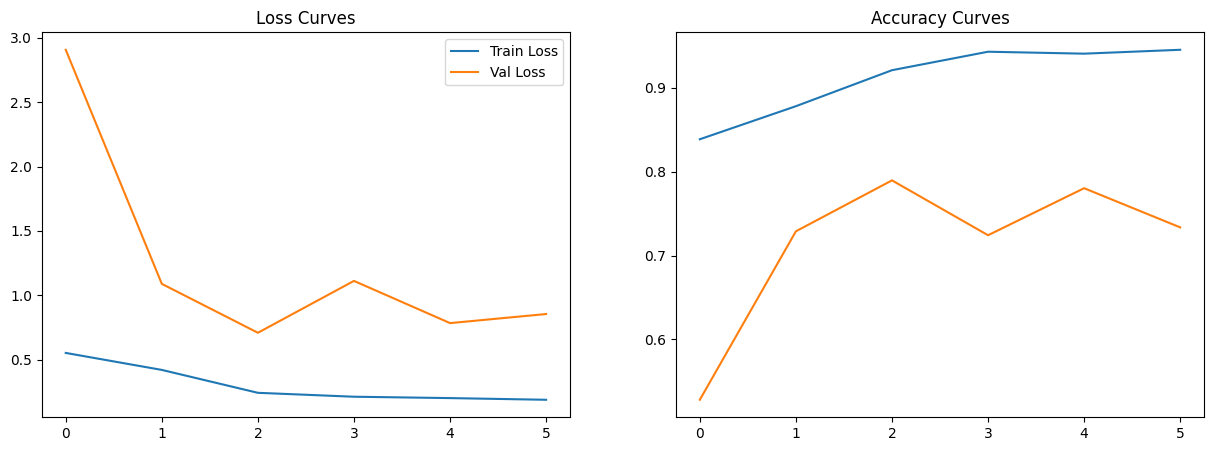

In [ ]:
from sklearn.metrics import classification_report, f1_score
import numpy as np

# 2. Обучение
optimizer_rare = torch.optim.Adam(rare_model.parameters(), lr=1e-3)
criterion_rare = nn.CrossEntropyLoss()

train_losses, val_losses = [], []
train_accs, val_accs = [], []
val_f1s = []

rare_model.train()
num_epochs = 20
best_f1 = 0
patience = 3
counter = 0

for epoch in range(num_epochs):
    rare_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    pbar = tqdm(train_loader_rare, desc=f"[Rare model] Эпоха {epoch+1}/{num_epochs}")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer_rare.zero_grad()
        outputs = rare_model(images)
        loss = criterion_rare(outputs, labels)
        loss.backward()
        optimizer_rare.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{correct/total:.3f}"
        })

    epoch_loss = running_loss / len(train_loader_rare)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # --- Валидация только на редких классах ---
    rare_model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for images, labels in val_loader_rare:
            images, labels = images.to(device), labels.to(device)
            outputs = rare_model(images)
            loss = criterion_rare(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    val_loss /= len(val_loader_rare)
    val_acc = val_correct / val_total
    val_f1 = f1_score(val_labels, val_preds, average='macro')
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)

    print(f"\nЭпоха {epoch+1}:")
    print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

    # --- Подробный отчёт только по редким классам ---
    print("\nОтчёт по редким классам (валидация):")
    print(classification_report(
        val_labels, val_preds,
        target_names=rare_labels,
        labels=[target2idx[label] for label in rare_labels],
        zero_division=0
    ))

    # Ранняя остановка
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(rare_model.state_dict(), rare_model_path)
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"\nРанняя остановка на эпохе {epoch+1}")
            break

# Загрузка лучших весов
rare_model.load_state_dict(torch.load(rare_model_path))

# Визуализация метрик
plot_metrics({
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs
})


## Общая модель

In [ ]:
# 8. Комбинированная модель
class CombinedModel(nn.Module):
    def __init__(self, main_model, rare_model, rare_indices):
        super().__init__()
        self.main_model = main_model
        self.rare_model = rare_model
        self.rare_indices = set(rare_indices)

    def forward(self, x, labels=None):
        logits = self.main_model(x)
        if labels is not None:
            # Используем истинные метки для выбора, где применять rare_model
            rerun_mask = torch.tensor([l.item() in self.rare_indices for l in labels], device=x.device)
            if rerun_mask.any():
                rare_logits = self.rare_model(x[rerun_mask])
                logits[rerun_mask] = rare_logits
        return logits


# Инициализация после обучения обеих моделей
rare_indices = [target2idx[label] for label in rare_labels]
combined_model = CombinedModel(main_model, rare_model, rare_indices).to(device)


In [ ]:
main_model.eval()
rare_model.eval()
combined_model.eval()

CombinedModel(
  (main_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [ ]:
# Инференс
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = combined_model(images, labels=labels)  # <-- теперь rare_model реально работает!
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
    all_labels, all_preds,
    target_names=[idx2target[i] for i in range(len(idx2target))]
))

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.87      0.97      0.91       192
           agnes_skinner       1.00      0.88      0.93         8
  apu_nahasapeemapetilon       1.00      0.98      0.99       135
           barney_gumble       1.00      0.76      0.86        21
            bart_simpson       0.96      0.96      0.96       278
            carl_carlson       0.89      0.85      0.87        20
charles_montgomery_burns       0.92      0.96      0.94       248
            chief_wiggum       0.97      0.96      0.96       207
         cletus_spuckler       0.54      0.78      0.64         9
          comic_book_guy       0.88      0.97      0.92       104
               disco_stu       0.25      0.50      0.33         2
          edna_krabappel       0.96      0.97      0.97       101
                fat_tony       1.00      0.40      0.57         5
                     gil       0.60      0.60      0.60         5
    groun

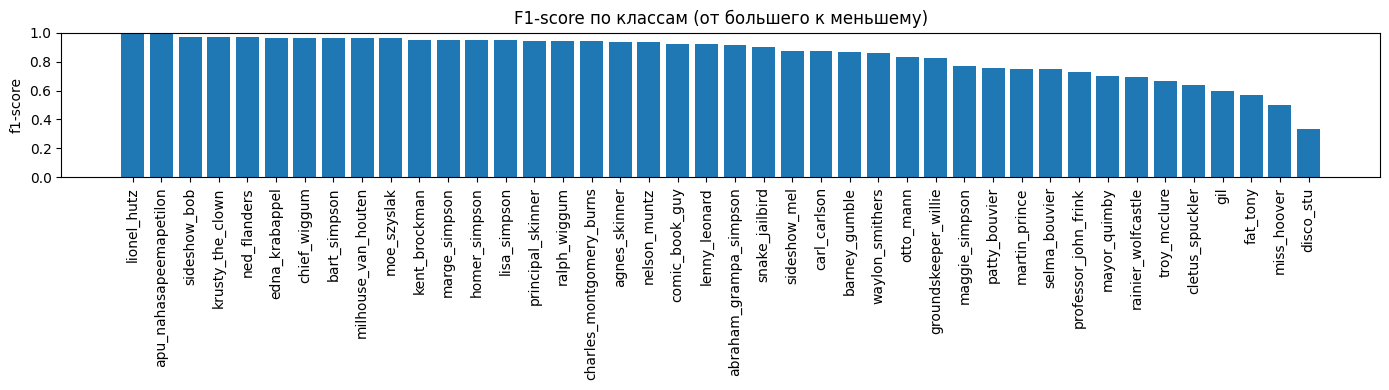

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Получаем словарь с метриками
report = classification_report(
    all_labels, all_preds,
    target_names=[idx2target[i] for i in range(len(idx2target))],
    output_dict=True
)

# Выбираем метрику
metric = 'f1-score'
classes = list(report.keys())[:-3]
values = [report[cls][metric] for cls in classes]

# Сортируем по убыванию
sorted_pairs = sorted(zip(classes, values), key=lambda x: x[1], reverse=True)
sorted_classes, sorted_values = zip(*sorted_pairs)

# Рисуем отсортированный график
plt.figure(figsize=(14, 4))
plt.bar(sorted_classes, sorted_values)
plt.title(f'{metric.capitalize()} по классам (от большего к меньшему)')
plt.xticks(rotation=90)
plt.ylabel(metric)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


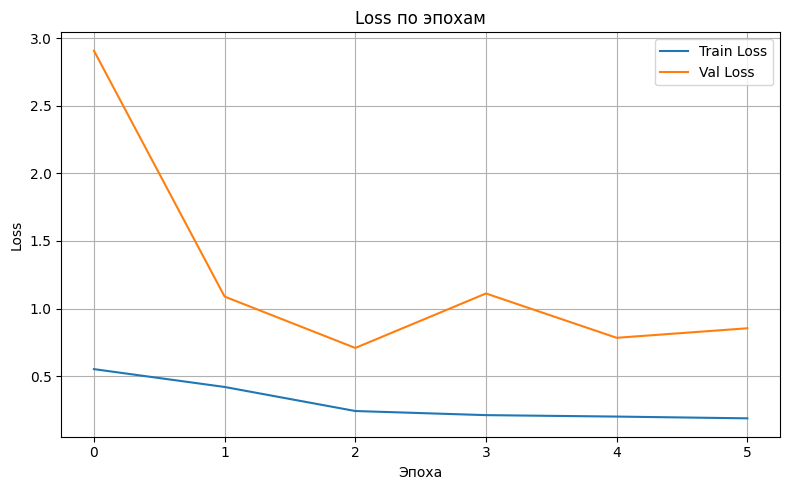

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
